In [ ]:
import pandas as pd
from collections import Counter
import pandas as pd
import os 
import re
import matplotlib.pyplot as plt
from langchain_openai import AzureChatOpenAI
from sklearn.model_selection import train_test_split

In [127]:
dataset_original = pd.read_csv('Shark_data.csv', index_col=0)

/var/folders/7m/q2yh5j193c5gf7sd2zd1g8pm0000gn/T/ipykernel_42804/43399676.py:1: DtypeWarning: Columns (10,17,18,19,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_original = pd.read_csv('Shark_data.csv', index_col=0)


In [410]:
dataset = dataset_original.copy()

In [413]:
def apply_and_count(dataset, func, *args, **kwargs):
    """
    Applies a function to the dataset and returns the number of deleted samples.
    
    Parameters:
    dataset (pd.DataFrame): The input DataFrame.
    func (function): The function to apply to the DataFrame.
    *args: Positional arguments to pass to the function.
    **kwargs: Keyword arguments to pass to the function.
    
    Returns:
    int: The number of samples deleted.
    """
    # Get the number of rows before applying the function
    initial_count = len(dataset)
    
    # Apply the function to the dataset
    func(dataset, *args, **kwargs)
    
    # Get the number of rows after applying the function
    final_count = len(dataset)
    
    # Calculate the number of deleted samples
    deleted_samples = initial_count - final_count
    
    print(f"Number of samples deleted: {deleted_samples}")

In [414]:
apply_and_count(dataset, pd.DataFrame.drop_duplicates, inplace=True)

Number of samples deleted: 2


In [415]:
dataset.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Unnamed: 9',
       ...
       'Unnamed: 246', 'Unnamed: 247', 'Unnamed: 248', 'Unnamed: 249',
       'Unnamed: 250', 'Unnamed: 251', 'Unnamed: 252', 'Unnamed: 253',
       'Unnamed: 254', 'Unnamed: 255'],
      dtype='object', length=256)

In [416]:
non_null_counts = dataset.count()
print(non_null_counts)

Case Number     6458
Date            6459
Year            6457
Type            6455
Country         6409
                ... 
Unnamed: 251       0
Unnamed: 252       0
Unnamed: 253       0
Unnamed: 254       0
Unnamed: 255       0
Length: 256, dtype: int64


In [417]:
zero_non_null_columns = dataset.columns[dataset.count() == 0]
print(zero_non_null_columns)

Index(['Unnamed: 22', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32',
       ...
       'Unnamed: 246', 'Unnamed: 247', 'Unnamed: 248', 'Unnamed: 249',
       'Unnamed: 250', 'Unnamed: 251', 'Unnamed: 252', 'Unnamed: 253',
       'Unnamed: 254', 'Unnamed: 255'],
      dtype='object', length=233)


In [418]:
dataset.drop(zero_non_null_columns, axis=1, inplace=True)

In [419]:
non_null_counts = dataset.count()
print(non_null_counts)

Case Number               6458
Date                      6459
Year                      6457
Type                      6455
Country                   6409
Area                      5997
Location                  5915
Activity                  5908
Name                      6245
Unnamed: 9                  28
Age                       3589
Injury                    6431
Fatal (Y/N)               5913
Time                      3068
Species                   3537
Investigator or Source    6441
pdf                       3066
href formula              3062
href                      3062
Case Number.1             3062
Case Number.2             3062
original order            3062
Unnamed: 23                  2
dtype: int64


In [420]:
#Remove data that has more than 30% missing values
threshold = len(dataset) * 0.8

apply_and_count(dataset, pd.DataFrame.dropna, axis=1, thresh=threshold, inplace=True)

Number of samples deleted: 0


In [421]:
dataset.count()

Case Number               6458
Date                      6459
Year                      6457
Type                      6455
Country                   6409
Area                      5997
Location                  5915
Activity                  5908
Name                      6245
Injury                    6431
Fatal (Y/N)               5913
Investigator or Source    6441
dtype: int64

In [422]:
dataset.drop(columns=['Investigator or Source', 'Case Number'], inplace=True)

Data on beach related activites for specific areas are not reported at area level. ChatGPT gives erroneous results for Florida for instance, where it says more surfers got there in August than January, which is the peak season. Will drop Area as not significant exposure data can be collected for it.

In [423]:
dataset.drop(columns=['Area'], inplace=True)

In [424]:
text_data = dataset['Location'].dropna()

# Combine all text into a single string
all_text = ' '.join(text_data)

# Remove punctuation and split into words
words = re.findall(r'\b\w+\b', all_text.lower())

# Count the frequency of each word
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(20)  # Change the number to get more or fewer words

print(most_common_words)

[('beach', 1612), ('county', 1533), ('island', 638), ('bay', 514), ('of', 341), ('volusia', 323), ('off', 319), ('river', 265), ('near', 260), ('new', 259), ('smyrna', 221), ('miles', 195), ('point', 191), ('port', 179), ('st', 173), ('the', 168), ('s', 168), ('north', 164), ('palm', 146), ('san', 141)]


Can't infer whether the attack occured far out in the sea, near the beach etc. It's mostly names of location for which we can not gather exposure data, will remove as well.

In [425]:
dataset.drop(columns=['Location'], inplace=True)

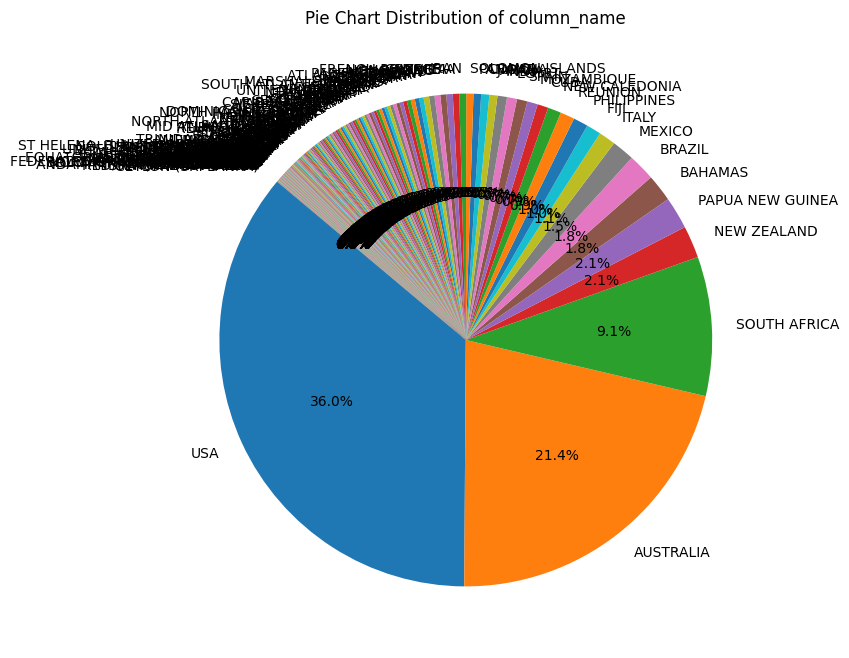

In [426]:
column_data = dataset['Country'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(column_data, labels=column_data.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart Distribution of column_name')
plt.show()

In [427]:
# Data is very skewed, will remove rare occurences

In [428]:
dataset["Country"].value_counts()

Country
USA                       2308
AUSTRALIA                 1374
SOUTH AFRICA               585
NEW ZEALAND                135
PAPUA NEW GUINEA           135
                          ... 
MALDIVE ISLANDS              1
NORTH SEA                    1
RED SEA / INDIAN OCEAN       1
BRITISH WEST INDIES          1
CEYLON (SRI LANKA)           1
Name: count, Length: 205, dtype: int64

In [429]:
country_counts = dataset['Country'].value_counts()
less_than_10 = country_counts[country_counts < 10]

In [430]:
print(f"Percentage of samples for countries with less than 10 samples: {less_than_10.sum() / len(dataset) * 100:.2f}%")

Percentage of samples for countries with less than 10 samples: 6.92%


In [431]:
dataset = dataset[~dataset['Country'].isin(less_than_10.index)]

In [432]:
dataset.shape

(6013, 8)

In [433]:
dataset.count()

Date           6012
Year           6010
Type           6010
Country        5962
Activity       5499
Name           5830
Injury         5987
Fatal (Y/N)    5510
dtype: int64

In [434]:
dataset["Date"]

index
0                05-Feb-2020
1       Reported 30-Jan-2020
2                17-Jan-2020
3                16-Jan-2020
4                13-Jan-2020
                ...         
6456             Before 1906
6457             Before 1903
6458             Before 1903
6459               1900-1905
6460               1883-1889
Name: Date, Length: 6013, dtype: object

In [435]:
dataset['Year']

index
0       2020.0
1       2020.0
2       2020.0
3       2020.0
4       2020.0
         ...  
6456       0.0
6457       0.0
6458       0.0
6459       0.0
6460       0.0
Name: Year, Length: 6013, dtype: float64

I want to aggregate the data per month, so the outliers that do not contain the months can be discarded since I can not make an educated inference on the month when it occured.

In [436]:
dataset = dataset.dropna(subset=['Date'])

In [437]:
pattern = r'([A-Za-z]{3}-\d{4})'

# Extract rows where the date_column matches the pattern
matching_rows = dataset[dataset['Date'].str.contains(pattern, regex=True)]


/var/folders/7m/q2yh5j193c5gf7sd2zd1g8pm0000gn/T/ipykernel_42804/3835995700.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = dataset[dataset['Date'].str.contains(pattern, regex=True)]


In [438]:
print(len(matching_rows))

5520


In [439]:
# Extract the matching pattern into a new column
dataset['extracted_date'] = dataset['Date'].str.extract(pattern)

In [440]:
init = len(dataset)
dataset.dropna(subset=['extracted_date'], inplace=True)
print(f"Number of samples deleted: {init - len(dataset)}")

Number of samples deleted: 492


In [441]:
dataset[['Month', 'Year']] = dataset['extracted_date'].str.split('-', expand=True)

In [442]:
dataset['Month'].value_counts()

Month
Jul    652
Aug    572
Sep    513
Jan    508
Jun    471
Apr    435
Oct    435
Dec    424
Nov    395
Mar    391
Feb    374
May    341
uly      4
ept      2
mer      1
rch      1
mid      1
Name: count, dtype: int64

In [443]:
# Define the replacements as a dictionary
replacements = {
    'uly': 'Jul',
    'ept': 'Sep', 
}

# Replace the values in the 'Month' column
dataset['Month'] = dataset['Month'].replace(replacements)

In [444]:
dataset = dataset[~dataset['Month'].isin([['mer', 'mid']])]

In [445]:
dataset.drop(columns=['Date', 'extracted_date'], inplace=True)

In [446]:
dataset.drop(columns=['Name'], inplace=True)

In [447]:
dataset.shape

(5520, 7)

In [448]:
dataset.count()

Year           5520
Type           5518
Country        5482
Activity       5108
Injury         5503
Fatal (Y/N)    5058
Month          5520
dtype: int64

Due to time constraints I'll just drop all missing values 

In [449]:
dataset.dropna(inplace=True)

In [450]:
dataset["Activity"].value_counts()[:20]

Activity
Surfing            949
Swimming           731
Fishing            366
Spearfishing       279
Wading             137
Bathing            124
Standing            93
Snorkeling          81
Diving              80
Body boarding       62
Scuba diving        58
Body surfing        46
Kayaking            33
Boogie boarding     31
Treading water      28
Pearl diving        23
Free diving         23
Surf skiing         19
Fell overboard      19
Boogie Boarding     17
Name: count, dtype: int64

In [451]:
# Categories to be made: Swimming, Fishing, Diving, Surfing, Other
categories = {
    "Swimming": ["swim", "bath", "float", "wad", "play"],
    "Fishing": ["fish", "catch", "spear", "net", "crab"],
    "Diving": ["dive", "snorkel", "scuba", "free"],
}

def categorize_element(element, categories, default="Other"):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in element.lower():
                return category
    return default

dataset['Activity_new'] = dataset['Activity'].apply(categorize_element, categories=categories)

In [452]:
dataset_checkpoint = dataset.copy()

In [454]:
dataset['Activity_new'].value_counts()

Activity_new
Other       2208
Swimming    1277
Fishing      988
Diving       242
Name: count, dtype: int64

In [455]:
dataset['Injury'].value_counts()[:30]

Injury
FATAL                          532
Foot bitten                     80
Leg bitten                      59
Left foot bitten                50
No injury                       49
Survived                        47
Right foot bitten               35
No injury, board bitten         31
Lacerations to foot             25
Hand bitten                     24
Foot lacerated                  20
Lacerations to left foot        20
Lacerations to right foot       20
Thigh bitten                    20
Right leg bitten                19
Arm bitten                      18
FATAL, body not recovered       18
Calf bitten                     17
No injury, surfboard bitten     16
Ankle bitten                    14
Minor injury                    13
Right thigh bitten              13
Left arm bitten                 12
Right calf bitten               12
Lacerations to right hand       12
Lacerations to right leg        11
Leg injured                     11
Heel bitten                     11
Left foot lac

In [456]:
injury_categories = {
    "Laceration": ["laceration", "cut", "bite", "tear", "wound"],
    "Fatal": ["death", "fatal"],
    "No injury": ["no injury", "unharmed", "uninjured", "no"],
}

dataset['Injuries_new'] = dataset['Injury'].apply(categorize_element, categories=injury_categories, default="Other Inury")

In [457]:
dataset['Injuries_new'].value_counts()

Injuries_new
Other Inury    1989
Laceration     1001
Fatal           898
No injury       827
Name: count, dtype: int64

In [458]:
dataset['Fatal (Y/N)'].value_counts()

Fatal (Y/N)
N          3726
Y           970
UNKNOWN      16
F             1
M             1
2017          1
Name: count, dtype: int64

In [459]:
mask_fatal_injuries = dataset['Injuries_new'] == 'Fatal'
mask_fatal_column = dataset['Fatal (Y/N)'] == 'Y'

In [460]:
overlap_mask = mask_fatal_injuries & mask_fatal_column
print(f"Number of samples where both columns agree: {overlap_mask.sum()}")

Number of samples where both columns agree: 894


This means that the fatal column does not add information

In [461]:
dataset.drop(columns=['Injury', 'Fatal (Y/N)'], inplace=True)

In [462]:
dataset['Type'].value_counts()

Type
Unprovoked             3783
Provoked                486
Sea Disaster            157
Watercraft               88
Boating                  86
Boat                     81
Invalid                  23
Questionable              8
Unverified                1
Under investigation       1
Boatomg                   1
Name: count, dtype: int64

In [463]:
# If the attack is not provoked, I will considered it unprovoked
dataset['Type_new'] = dataset['Type'].apply(lambda x: x if x == 'Provoked' else 'Unprovoked')

In [464]:
dataset.drop(columns=['Type'], inplace=True)

In [465]:
dataset.columns

Index(['Year', 'Country', 'Activity', 'Month', 'Activity_new', 'Injuries_new',
       'Type_new'],
      dtype='object')

In [466]:
dataset['Month']

index
0       Feb
1       Jan
2       Jan
3       Jan
4       Jan
       ... 
6391    May
6406    Apr
6448    Jul
6449    Jul
6450    Jul
Name: Month, Length: 4715, dtype: object

# Population Estimation and Exposure Metrics

In [573]:
#Grouping per year for MongoDB
grouped_year = dataset.groupby(['Country', 'Activity_new', 'Month', "Year", 'Injuries_new', 'Type_new']).size().reset_index(name='count')

# Calculate the average number of samples per month by Country and Activity
average_samples_year = grouped_year.groupby(['Country','Year', 'Month','Activity_new', 'Injuries_new', 'Type_new'])['count'].mean().reset_index(name='occurence_per_month')

average_samples_year.head()

,Country,Year,Month,Activity_new,Injuries_new,Type_new,occurence_per_month
0,ATLANTIC OCEAN,1882,Jan,Other,Fatal,Unprovoked,1.0
1,ATLANTIC OCEAN,1885,Aug,Other,Fatal,Unprovoked,1.0
2,ATLANTIC OCEAN,1890,Oct,Other,Fatal,Unprovoked,1.0
3,ATLANTIC OCEAN,1892,Dec,Other,Fatal,Unprovoked,1.0
4,ATLANTIC OCEAN,1916,Jun,Other,Fatal,Unprovoked,1.0


In [574]:
average_samples_year.to_csv('shark_data_cleaned_with_year.csv')

In [467]:
grouped = dataset.groupby(['Country', 'Activity_new', 'Month', "Year", 'Injuries_new', 'Type_new']).size().reset_index(name='count')

# Calculate the average number of samples per month by Country and Activity
average_samples = grouped.groupby(['Country', 'Month','Activity_new', 'Injuries_new', 'Type_new'])['count'].mean().reset_index(name='occurence_per_month')

# Display the result
print(average_samples)

             Country Month Activity_new Injuries_new    Type_new  \
0     ATLANTIC OCEAN   Aug        Other        Fatal  Unprovoked   
1     ATLANTIC OCEAN   Dec        Other        Fatal  Unprovoked   
2     ATLANTIC OCEAN   Dec        Other    No injury  Unprovoked   
3     ATLANTIC OCEAN   Feb        Other    No injury  Unprovoked   
4     ATLANTIC OCEAN   Jan        Other        Fatal  Unprovoked   
...              ...   ...          ...          ...         ...   
1496         VIETNAM   Jul     Swimming  Other Inury  Unprovoked   
1497         VIETNAM   Jun      Fishing  Other Inury    Provoked   
1498         VIETNAM   Jun     Swimming   Laceration  Unprovoked   
1499         VIETNAM   May        Other   Laceration  Unprovoked   
1500         VIETNAM   May     Swimming   Laceration  Unprovoked   

      occurence_per_month  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  
...            

If I am going to be interested in the probability of getting bitten if I go surfing in Australia for instance it would be very unlikley that I would be interested in seeing what the probability would be if I provoke or not 

In [468]:
grouped_only_activ = dataset.groupby(['Country', 'Activity_new', 'Month', "Year"]).size().reset_index(name='count')

# Calculate the average number of samples per month by Country and Activity
average_samples_only_activ = grouped.groupby(['Country', 'Month','Activity_new'])['count'].mean().reset_index(name='average_samples_per_month')

# Display the result
print(average_samples_only_activ)

            Country Month Activity_new  average_samples_per_month
0    ATLANTIC OCEAN   Aug        Other                       1.00
1    ATLANTIC OCEAN   Dec        Other                       1.00
2    ATLANTIC OCEAN   Feb        Other                       1.00
3    ATLANTIC OCEAN   Jan        Other                       1.25
4    ATLANTIC OCEAN   Jul        Other                       1.00
..              ...   ...          ...                        ...
757         VIETNAM   Jul     Swimming                       1.00
758         VIETNAM   Jun      Fishing                       1.00
759         VIETNAM   Jun     Swimming                       1.00
760         VIETNAM   May        Other                       1.00
761         VIETNAM   May     Swimming                       1.00

[762 rows x 4 columns]


In [244]:
average_samples_only_activ.head()

,Country,Month,Activity_new,average_samples_per_month
0,ATLANTIC OCEAN,Aug,Other,1.00
1,ATLANTIC OCEAN,Dec,Other,1.00
2,ATLANTIC OCEAN,Feb,Other,1.00
3,ATLANTIC OCEAN,Jan,Other,1.25
4,ATLANTIC OCEAN,Jul,Other,1.00


In [245]:
len(dataset[dataset["Country"]=="ATLANTIC OCEAN"])

14

In [ ]:
llm = AzureChatOpenAI(
    api_version = "2024-08-01-preview",
    api_key = "***",
    azure_endpoint = "***",
    temperature = 0.0,
    model_name = "gpt-4"
)


In [290]:
template_prompt = """Can you give me the number of people doing the following activity {activity} in the month of {month} in the following location {location}?
 If activity is Other, consider any type of nautical activity excluding swimming, diving or fishing.
Please output just the number, if no number is found, make a guess and please output just the number, no justification needed. Take in account the population of the country.
 Please do not separate the numbers and output them as a single number."""

In [320]:
import pickle
exposure_metric = []

def run_llm_for_index(index_start, index_end):
    for index, row in average_samples_only_activ.iloc[index_start:index_end].iterrows():
        prompt = template_prompt.format(activity=row['Activity_new'], month=row['Month'], location=row['Country'])
        result = llm(prompt)
        
        number_of_people = int(result.content)
        exposure_metric.append(number_of_people)
        print(index)
        if index % 10 == 0 or index == index_end-1:
            print(f"Processed {index} samples")
            print(f"Number of people: {number_of_people} for activity {row['Activity_new']} in the month of {row['Month']} in the country {row['Country']}")
            with open(f"inter_openai/exposure_metric_{index}.pkl", "wb") as f:
                pickle.dump(exposure_metric[-10:], f)

In [ ]:
def read_pickle(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

def generate_combined_file(folder_name):
    combined_list = []
    # Iterate over all files in the folder
    sorted_files = sorted(os.listdir(folder_name))
    for filename in sorted_files:
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_name, filename)
            # Load the contents of the pickle file
            data = read_pickle(file_path)
            
            if len(data) != 10 and filename not in [sorted_files[0], sorted_files[-1]]: 
                #Could introduce a call here to the LLM
                print(f"Found a file with less than 10 elements: {filename}")
                index = int(filename.split('_')[-1].split('.')[0])
                run_llm_for_index(index + 1, index + 11)
                data = read_pickle(file_path)

            combined_list.extend(data)
    return combined_list


In [327]:
combined_list = generate_combined_file("inter_openai")

In [469]:
average_samples_only_activ['participants'] = combined_list

In [ ]:
# Merge the two datasets and broadcast participants to the dataset
dataset_with_exposure = pd.merge(average_samples, average_samples_only_activ, on=['Country', 'Month', 'Activity_new'], how='left')

In [472]:
dataset_with_exposure.head(20)

,Country,Month,Activity_new,Injuries_new,Type_new,occurence_per_month,average_samples_per_month,participants
0,ATLANTIC OCEAN,Aug,Other,Fatal,Unprovoked,1.0,1.000,45
1,ATLANTIC OCEAN,Dec,Other,Fatal,Unprovoked,1.0,1.000,45
2,ATLANTIC OCEAN,Dec,Other,No injury,Unprovoked,1.0,1.000,45
3,ATLANTIC OCEAN,Feb,Other,No injury,Unprovoked,1.0,1.000,45
4,ATLANTIC OCEAN,Jan,Other,Fatal,Unprovoked,1.0,1.250,45
5,ATLANTIC OCEAN,Jan,Other,No injury,Unprovoked,2.0,1.250,45
6,ATLANTIC OCEAN,Jan,Other,Other Inury,Unprovoked,1.0,1.250,45
7,ATLANTIC OCEAN,Jul,Other,Fatal,Unprovoked,1.0,1.000,45
8,ATLANTIC OCEAN,Jun,Other,Fatal,Unprovoked,1.0,1.000,450
9,ATLANTIC OCEAN,Oct,Other,Fatal,Unprovoked,1.0,1.000,0


In [473]:
dataset_with_exposure.drop(columns=['average_samples_per_month'], inplace=True)

In [474]:
dataset_with_exposure['Injuries_new'] = dataset_with_exposure['Injuries_new'].replace({'Other':'Other Injury'})

In [475]:
days_in_month = {
    'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30,
    'Jul': 31, 'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31
}

In [476]:
dataset_with_exposure['Days_in_Month'] = dataset_with_exposure['Month'].map(days_in_month)

In [477]:
# Calculate exposure rate per day in a given month for a given activity times 100 to make it a percentage
dataset_with_exposure['exposure_rate'] = ((dataset_with_exposure['occurence_per_month'] / dataset_with_exposure['Days_in_Month'] ) / dataset_with_exposure['participants']) * 100

In [478]:
dataset_with_exposure['exposure_rate'].isna().sum()

np.int64(2)

In [479]:
dataset_with_exposure['exposure_rate'].fillna(0, inplace=True)

/var/folders/7m/q2yh5j193c5gf7sd2zd1g8pm0000gn/T/ipykernel_42804/1179671759.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_with_exposure['exposure_rate'].fillna(0, inplace=True)


In [571]:
dataset_with_exposure['Activity_new'].value_counts()

Activity_new
Other       524
Fishing     439
Swimming    384
Diving      154
Name: count, dtype: int64

In [572]:
dataset_with_exposure_for_db = dataset_with_exposure.copy()
dataset_with_exposure_for_db.drop(columns=['participants', 'Days'], inplace=True)

,Country,Month,Activity_new,Injuries_new,Type_new,occurence_per_month,participants,Days_in_Month,exposure_rate
0,ATLANTIC OCEAN,Aug,Other,Fatal,Unprovoked,1.0,45,31.0,0.071685
1,ATLANTIC OCEAN,Dec,Other,Fatal,Unprovoked,1.0,45,31.0,0.071685
2,ATLANTIC OCEAN,Dec,Other,No injury,Unprovoked,1.0,45,31.0,0.071685
3,ATLANTIC OCEAN,Feb,Other,No injury,Unprovoked,1.0,45,28.0,0.079365
4,ATLANTIC OCEAN,Jan,Other,Fatal,Unprovoked,1.0,45,31.0,0.071685


In [511]:
dataset_with_exposure_dummies = pd.get_dummies(dataset_with_exposure, columns=['Month'], prefix='Month')

In [512]:
dataset_with_exposure_dummies = pd.get_dummies(dataset_with_exposure_dummies, columns=['Activity_new'], prefix='Activity')
dataset_with_exposure_dummies = pd.get_dummies(dataset_with_exposure_dummies, columns=['Injuries_new'], prefix='Injuries')
dataset_with_exposure_dummies = pd.get_dummies(dataset_with_exposure_dummies, columns=['Type_new'], prefix='Type')
dataset_with_exposure_dummies = pd.get_dummies(dataset_with_exposure_dummies, columns=['Country'])

In [514]:
dataset_with_exposure_dummies.head()

,occurence_per_month,participants,Days_in_Month,exposure_rate,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,...,Country_SOUTH ATLANTIC OCEAN,Country_SPAIN,Country_SRI LANKA,Country_TONGA,Country_TURKEY,Country_UNITED KINGDOM,Country_USA,Country_VANUATU,Country_VENEZUELA,Country_VIETNAM
0,1.0,45,31.0,0.071685,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,45,31.0,0.071685,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,45,31.0,0.071685,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.0,45,28.0,0.079365,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.0,45,31.0,0.071685,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [515]:
dataset_with_exposure_dummies.drop(columns=['Days_in_Month', 'participants'], inplace=True)

In [564]:
dataset_with_exposure_dummies.to_csv('shark_data_cleaned.csv')

# Training the Model

Since we already have the approcimate probabilities in the exposure rate column we can consider those as the target variable. The exposure rate has been constructed by taking the monthly average over all years of the number of people doing a particular activity, in a certain location, who suffered an injury and an attack type and divided it by the the monthly average over all years of the number of people doing a particular activity, in a certain location times 100.

In [516]:
y = dataset_with_exposure_dummies['exposure_rate']
y.replace([np.inf, -np.inf], 0, inplace=True)
X = dataset_with_exposure_dummies.drop(columns=['occurence_per_month', 'exposure_rate'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [580]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

class SharkAttackRatePredictor:
    def __init__(self, model_type='adaboost', estimators=100, learning_rate=0.1, max_depth=3):
        if model_type == 'adaboost':
            self.model = AdaBoostRegressor(
                n_estimators=estimators,
                learning_rate=learning_rate,
                random_state=42,
                estimator=DecisionTreeRegressor(max_depth=max_depth),
            )
        elif model_type == 'linear':
            self.model = LinearRegression()
        else:
            raise ValueError("model_type must be 'adaboost' or 'linear'")
            
        self.feature_names = None
    
    def fit(self, X, y):
        """
        Fit model on prepared data
        """
        self.model.fit(X, y)
        self.feature_names = X.columns
        return self
    
    def predict(self, new_data):
        """
        Make predictions for new data
        """
        return self.model.predict(new_data)
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate model performance
        """
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        return {
            'mse': mse,
            'rmse': np.sqrt(mse),
            'r2': r2,
            'mae': mae
        }
    
    def plot_feature_importance(self):
        """
        Plot feature importance (for AdaBoost)
        """
        if isinstance(self.model, AdaBoostRegressor):
            importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            })
            importance = importance.sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            plt.bar(importance['feature'][:15], importance['importance'][:15])
            plt.xticks(rotation=45, ha='right')
            plt.title('Feature Importance')
            plt.tight_layout()
            plt.show()

AdaBoost Metrics: {'mse': np.float64(0.002768818907275642), 'rmse': np.float64(0.052619567722242286), 'r2': -0.30654954165615655, 'mae': np.float64(0.02801375326975139)}
Linear Regression Metrics: {'mse': np.float64(0.0021493499025771225), 'rmse': np.float64(0.0463610817666836), 'r2': -0.014234669768989239, 'mae': np.float64(0.02016061515902932)}


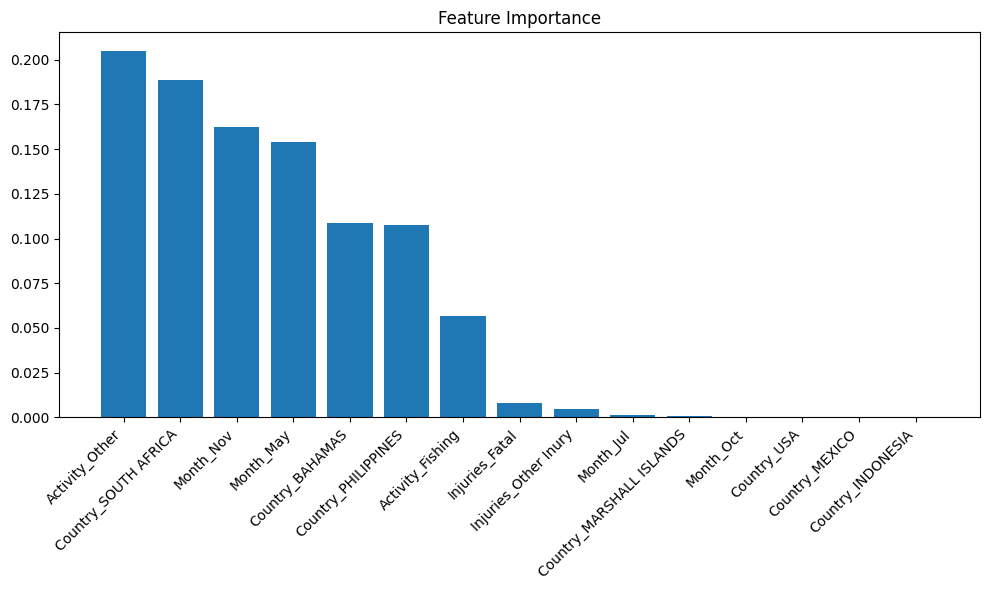

In [550]:
ada_model = SharkAttackRatePredictor(model_type='adaboost')
ada_model.fit(X_train, y_train)
ada_metrics = ada_model.evaluate(X_test, y_test)

# Train and evaluate Linear Regression
lr_model = SharkAttackRatePredictor(model_type='linear')
lr_model.fit(X_train, y_train)
lr_metrics = lr_model.evaluate(X_test, y_test)

print("AdaBoost Metrics:", ada_metrics)
print("Linear Regression Metrics:", lr_metrics)

# Plot feature importance for AdaBoost
ada_model.plot_feature_importance()

In [551]:

import pandas as pd
import numpy as np

def grid_search_adaboost(X, y):
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'estimator': [
            DecisionTreeRegressor(max_depth=1),
            DecisionTreeRegressor(max_depth=2),
            DecisionTreeRegressor(max_depth=3)
        ]
    }
    
    # Initialize AdaBoost
    ada = AdaBoostRegressor(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        ada, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    # Get results
    results = pd.DataFrame(grid_search.cv_results_)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return best_params, best_score, results

In [552]:
# Quick grid search on ADA
best_params, best_score, results = grid_search_adaboost(X, y)
    
print("Best Parameters:", best_params)
print("Best Score (negative MSE):", best_score)

# Display top 5 parameter combinations
top_results = results.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score']
]
print("\nTop 5 Parameter Combinations:")
print(top_results)

Best Parameters: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 200}
Best Score (negative MSE): -0.003051707068981886

Top 5 Parameter Combinations:
                                               params  mean_test_score  \
34  {'estimator': DecisionTreeRegressor(max_depth=...        -0.003052   
35  {'estimator': DecisionTreeRegressor(max_depth=...        -0.003053   
17  {'estimator': DecisionTreeRegressor(max_depth=...        -0.003057   
16  {'estimator': DecisionTreeRegressor(max_depth=...        -0.003058   
33  {'estimator': DecisionTreeRegressor(max_depth=...        -0.003059   

    std_test_score  
34        0.003870  
35        0.003839  
17        0.003885  
16        0.003896  
33        0.003897  


In [562]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

class ModelComparison:
    def __init__(self):
        self.models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=100,
                random_state=42
            ),
            'SVR': SVR(
                kernel='rbf'
            ),
            'AdaBoostRegressor': AdaBoostRegressor(
                n_estimators=200,
                learning_rate=0.01,
                random_state=42,
                estimator=DecisionTreeRegressor(max_depth=3),
            ),
            'Linear Regression': LinearRegression()
            
        }
        self.results = {}
        
    def compare_models(self, X, y):
        """Compare all models using cross-validation"""
        for name, model in self.models.items():
            scores = cross_val_score(
                model,
                X, y,
                cv=5,
                scoring='neg_mean_squared_error'
            )
            rmse_scores = np.sqrt(-scores)
            self.results[name] = {
                'mean_rmse': rmse_scores.mean(),
                'std_rmse': rmse_scores.std(),
            }
            
        return pd.DataFrame(self.results).T
    
    def fit_best_model(self, X_train, y_train, X_test, y_test):
        """Fit and evaluate best performing model"""
        best_model_name = min(
            self.results.items(),
            key=lambda x: x[1]['mean_rmse']
        )[0]
        
        model = self.models[best_model_name]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        return {
            'model_name': best_model_name,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'model': model
        }

In [563]:
comparison = ModelComparison()
results = comparison.compare_models(X, y)
print("\nModel Comparison Results:")
print(results)

# Fit best model
best_model_results = comparison.fit_best_model(
    X_train, y_train, X_test, y_test
)
print("\nBest Model Results:")
print(f"Model: {best_model_results['model_name']}")
print(f"RMSE: {best_model_results['rmse']:.6f}")
print(f"R²: {best_model_results['r2']:.3f}")


Model Comparison Results:
                      mean_rmse      std_rmse
Random Forest      4.854106e-02  2.999493e-02
Gradient Boosting  4.760037e-02  2.935996e-02
SVR                6.294658e-02  2.252140e-02
AdaBoostRegressor  4.669438e-02  2.951850e-02
Linear Regression  4.237710e+11  5.490818e+11

Best Model Results:
Model: AdaBoostRegressor
RMSE: 0.046022
R²: 0.001


In [ ]:
#Final training of AdaBoost model
ada_model = SharkAttackRatePredictor(model_type='adaboost', estimators=200, learning_rate=0.01, max_depth=3)
ada_model.fit(X_train, y_train)
ada_metrics = ada_model.evaluate(X_test, y_test)
print("AdaBoost Metrics:", ada_metrics)

AdaBoost Metrics: {'mse': np.float64(0.002118023101857949), 'rmse': np.float64(0.046021984983896), 'r2': 0.0005478127594412685, 'mae': np.float64(0.01801672108260128)}


In [ ]:
#Save the adaboost model to pickle 
with open('trained_adaboost.pkl', 'wb') as f:
    pickle.dump(ada_model, f)